数据网站，http://quotes.money.163.com/stock

下载交易历史数据：http://quotes.money.163.com/cjmx/2019/20191120/1300127.xls
，获得一个SCV文件。结构如下：
成交时间,成交价,价格变动,成交量（手）,成交额（元）,性质
09:30:06,17.2,-0.05,50,86011,卖盘
09:30:09,17.21,0.01,887,1525626,买盘
大概每3秒一条记录。

## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


## Data Plot

/Users/wj/项目/langstudy/python/py3study/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


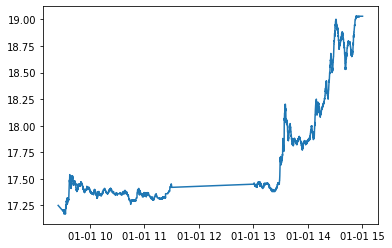

In [2]:
data = pd.read_csv('data/ashare/30012720191120.csv', usecols = [0, 1, 3], converters={
    0:lambda x:datetime.strptime(x, '%H:%M:%S')
})
# print(data)

training_set = data.iloc[:,1].values
timeline = data.iloc[:,0].values

plt.plot(timeline, training_set, )

plt.show()

In [3]:
def local_price(file):
    data = pd.read_csv(file, usecols=[0, 1, 3], converters={
        0: lambda x: datetime.strptime(x, '%H:%M:%S')
    })

    for i in data.iloc[:,1].values:
        yield i

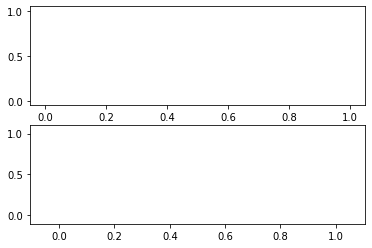

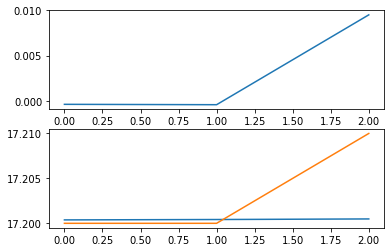

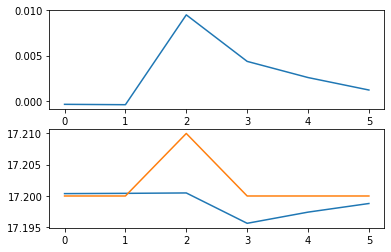

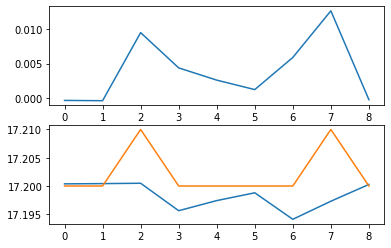

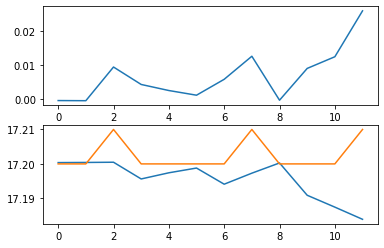

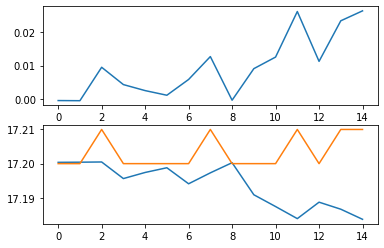

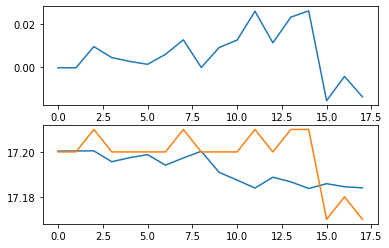

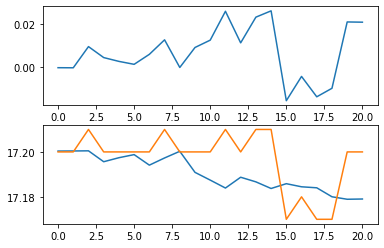

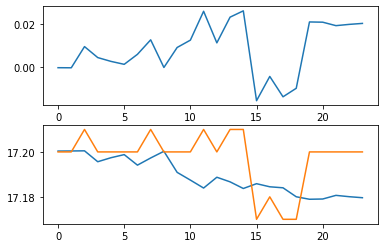

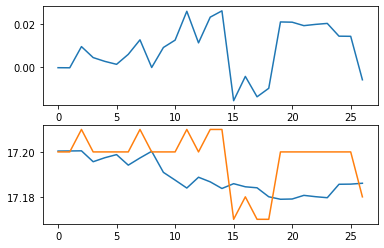

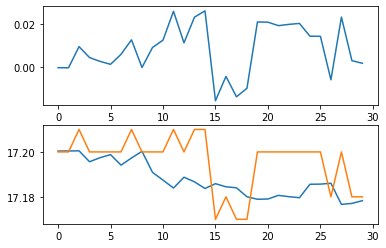

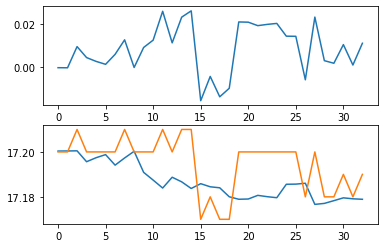

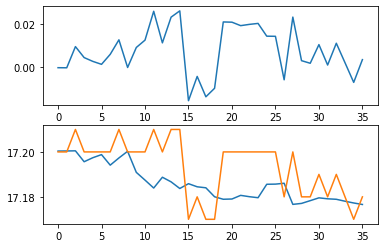

KeyboardInterrupt: 

In [8]:
from stock import train, sliding_windows, predict, LSTM
import time

loader = local_price('data/ashare/30012720191120.csv')

num_epochs = 100

num_classes = 3
seq_length = 12

input_size = 1
hidden_size = 2
num_layers = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

sc = MinMaxScaler()

bucket = []
data = []
predict_y = None
aloss_list = []
loss_list = []
x_list = []
y_list = []
for price in loader:

    bucket.append([float(price)])
    # print(bucket, data)
    if len(bucket) >= seq_length:
        data.append(bucket)
        
        if len(data) > 1:
            if predict_y is not None:
                x = torch.tensor(predict_y)
                y = torch.tensor(bucket[:num_classes]).view(-1)
                loss = y - x
                aloss = loss.sum()/num_classes
                
                loss_list += list(loss.view(-1).numpy())
                x_list += list(x.view(-1).numpy())
                y_list += list(y.view(-1).numpy())
                aloss_list.append(aloss)

                # print(x)
#                 print(y)
#                 print(aloss, elapsed)
#                 print()

            t1 = time.time()
            training_data = torch.Tensor(data)
            training_data = sc.fit_transform(training_data.view(-1, 1))
            # training_data = torch.Tensor([training_data])

            x, y = sliding_windows(training_data, seq_length, num_classes)
            trainX = torch.Tensor(np.array(x))
            trainY = torch.Tensor(np.array(y))

            loss = train(lstm, num_epochs, num_classes, trainX, trainY)
            elapsed = time.time() - t1

            predict_data = data[-1]
            predict_y = predict(lstm, predict_data)
#             print(predict_y)
            plt.subplot(2,1,1)
            plt.plot(loss_list, )
            plt.subplot(2,1,2)
            plt.plot(x_list, )
            plt.plot(y_list, )
            plt.show()

        bucket = bucket[num_classes:]


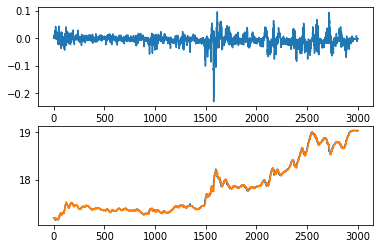

In [7]:
plt.subplot(2,1,1)
plt.plot(loss_list, )
plt.subplot(2,1,2)
plt.plot(x_list, )
plt.plot(y_list, )
plt.show()